In [416]:
%pip install -qU pypdf
%pip install -U langchain
%pip install -U langchain-community
%pip install -U langchain-groq
%pip install langchain-huggingface
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [417]:
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama

In [418]:
llm = ChatOllama(model="mistral")

In [419]:
from IPython.display import display, Markdown

In [420]:
prompt = ''' 
    messages: Segundo a NASA quais seriam os benefícios cientificos de ir para marte
'''

In [421]:
resposta = llm.invoke(prompt)

In [422]:
import textwrap

print(textwrap.fill(str(resposta), width=190))


content=' De acordo com a NASA, ir para Marte traria inúmeros benefícios científicos. Algumas vantagens que podem se esperar incluem:\n\n1. Avaliação da origem da vida: Marte é considerado
um candidato promissor no busca pela existência de vida extraterrestre, já que a planetologia sugere que o planeta possuía água líquida em seu passado. O estudo do solo marciano poderia
fornecer evidências sobre se Marte alguma vez apresentou condições habitáveis para o desenvolvimento de vida, ou ainda pode ser um local interessante para a busca por vida extraterrestre
atual.\n\n2. Avaliação da história climática: O estudo do clima marciano no passado e presente pode fornecer informações importantes sobre como o planeta se adaptou ao longo dos anos,
incluindo mudanças na composição atmosférica, a presença ou ausência de água líquida e o papel da vida na evolução do clima.\n\n3. Avaliação geológica: O estudo da geologia marciana pode
fornecer informações importantes sobre os processos geológicos que 

In [423]:
url = 'NASA.pdf'

In [424]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(url)
pages = []
for page in loader.lazy_load():
    pages.append(page)

In [425]:
print(f"{pages[0].metadata}\n")

{'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 18.2 (Windows)', 'creationdate': '2023-04-06T17:28:28-04:00', 'moddate': '2023-04-06T17:29:25-04:00', 'trapped': '/False', 'source': 'NASA.pdf', 'total_pages': 78, 'page': 0, 'page_label': '1'}



In [426]:
print(pages[0].page_content)

NASA’S 
MOON TO MARS 
STRATEGY AND 
OBJECTIVES 
DEVELOPMENT
A blueprint for sustained 
human presence and 
exploration throughout 
the Solar System
National Aeronautics and
Space Administration


In [427]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_huggingface import HuggingFaceEmbeddings

In [428]:
embed_model = HuggingFaceEmbeddings(model_name="mixedbread-ai/mxbai-embed-large-v1")

In [429]:
vector_store = InMemoryVectorStore.from_documents(pages,embed_model)

In [430]:
docs = vector_store.similarity_search("Objectives Development Process", k=2)

In [431]:
for doc in docs:
    print(f'Page {doc.metadata["page"]}: {doc.page_content[:300]}\n')

Page 42: APPENDIX B: OBJECTIVES DEVELOPMENT PROCESS
In accordance with the methodology principle of Architect from the Right, in November 2021, the NASA Executive Council 
tasked the mission directorates to draft a set of top-level goals and objectives necessary to achieve the Moon to Mars 
endeavor. The tas

Page 13: objective-baSed approach architect From the riGht / execute From the leFt
Architect from the right 
– work backwards from 
the defined goal and 
establish a complete set 
of elements that will be 
required for success.
NASA’s Moon to Mars strategy is guided by both a robust systems engineering proce



In [432]:
retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": 5})


In [433]:
from langchain_core.prompts import ChatPromptTemplate

In [434]:
template = """
    You are a helpful assistant that only gives answers bases on the given context. If the answer is not in the context, say "I do not know".capitalize
    
    Context: {context}
    
    Question: {question}
    
    Answer:
"""

In [435]:
prompt = ChatPromptTemplate.from_template(template)

In [436]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [437]:
chain = (
    {
        "context": retriever, "question": RunnablePassthrough()
    }
    | prompt 
    | llm
    | StrOutputParser()
)

In [438]:
from IPython.display import display, Markdown

In [439]:
response = chain.invoke("What is the Objectives Development Process ?")
display(Markdown(response))

 The Objectives Development Process is a methodology that was used to develop top-level goals and objectives for NASA's Moon to Mars strategy. This process was facilitated by the Federated Board, which reached consensus on an initial draft set of objectives by March 2022. The process involved identifying goals and binning them into four distinct tracks: Operations, Infrastructure, Transportation and Habitation, and Science. Each track was led by a respective mission directorate within NASA. The objectives development process also involved receiving feedback from the public, industry, academia, and international partners, and revising the goals and objectives based on this feedback. More details of the objectives development process can be found in Appendix B: Objectives Development Process in the given context.

In [440]:
from langchain_core.tools import tool

In [441]:
@tool
def pega_contexto(query: str) -> str:
    """Pega o contexto baseado em uma pesquisa sobre a NASA."""
    retriever = vector_store.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [442]:
def carrega_pdf(url:str)->str:
    loader = PyPDFLoader(url)
    pages = []
    for page in loader.load():
        pages.append(page)
    vectorstore = InMemoryVectorStore.from_documents(pages,embed_model)
    return vectorstore

In [470]:
vector_store = carrega_pdf("NASA.pdf")

In [443]:
vector_store_agriculture = carrega_pdf("agriculture.pdf")


In [444]:
vector_store_dengue = carrega_pdf('dengue.pdf')

In [445]:
@tool
def pega_contexto_agriculture(query: str) -> str:
    """Pega o contexto sobre agricultura baseado em uma pesquisa."""
    retriever = vector_store_agriculture.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [446]:
@tool
def pega_contexto_dengue(query: str) -> str:
    """Pega o contexto sobre dengue baseado em uma pesquisa."""
    retriever = vector_store_dengue.as_retriever()
    resultado = retriever.invoke(query)
    return resultado

In [447]:
tools = [pega_contexto,pega_contexto_agriculture,pega_contexto_dengue]

In [448]:
pega_contexto_dengue.invoke("Cases of dengue we had since the beginning of 2025?")

[Document(id='78bcac08-cd5a-4e0b-8b96-bec257506fea', metadata={'producer': 'Microsoft® Word for Microsoft 365', 'creator': 'Microsoft® Word for Microsoft 365', 'creationdate': '2022-04-05T11:18:49+02:00', 'author': 'ECDC', 'keywords': 'dengue; annual epidemiological report; EU/EEA', 'moddate': '2022-04-05T11:21:18+02:00', 'subject': 'Dengue', 'title': 'Dengue - Annual Epidemiological Report for 2020', 'source': 'dengue.pdf', 'total_pages': 8, 'page': 0, 'page_label': '1'}, page_content='Suggested citation: European Centre for Disease Prevention and Control. Dengue. In: ECDC. Annual epidemiological report for \n2020. Stockholm: ECDC; 2022. \n \nStockholm, April 2022 \n \n© European Centre for Disease Prevention and Control, 2022. Reproduction is authorised, provided the source is acknowledged. \n \n \n \n \n \n \n \n \n \n \n \n SURVEILLANCE REPORT \nDengue \n \nAnnual Epidemiological Report for 2020 \n \n \n \n \n \nKey facts \n• For 2020, 26 EU/EEA countries reported 1 957 cases of de

In [449]:
from langgraph.prebuilt import create_react_agent

In [450]:
system_prompt = """
    You are a helpful assistant. Use ONLY the provided context to answer. 
    If the context seems partially related, try to summarize it instead of saying 'I don't know'. 
    If there is truly no relevant information, then say 'I don't know'.

    - pega_contexto: Tool that returns the context based on the users query if the query is about NASA and space travels.
    - pega_contexto_agriculture: Tool that returns the context based on the users query if the query is about agriculture.
    - pega_contexto_dengue: Tool that returns the context based on the users query if the query is about dengue.
"""

In [451]:
agente_pdf = create_react_agent(model = llm, tools = tools,prompt= system_prompt)

In [452]:
resposta = agente_pdf.invoke({"messages": [("user", "What are the Objectives Development Process in NASA?")]})
resposta

{'messages': [HumanMessage(content='What are the Objectives Development Process in NASA?', additional_kwargs={}, response_metadata={}, id='be0f65fb-44fb-4c03-a639-0535a8a16280'),
  AIMessage(content=" I don't have specific information about the Objectives Development Process in NASA within the provided context. The functions you've listed pertain to context extraction for queries related to NASA, agriculture, and dengue. However, without more detailed context or additional information, I cannot accurately answer this question.", additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-08-18T14:18:28.0752095Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2395387400, 'load_duration': 13154000, 'prompt_eval_count': 377, 'prompt_eval_duration': 330814800, 'eval_count': 63, 'eval_duration': 2047825100, 'model_name': 'mistral'}, id='run--04bc3bec-bad1-4e4d-8608-8868dd2a6377-0', usage_metadata={'input_tokens': 377, 'output_tokens': 63, 'total_tokens': 440})]

In [453]:

mensagem_final = resposta["messages"][-1].content
print(mensagem_final)

 I don't have specific information about the Objectives Development Process in NASA within the provided context. The functions you've listed pertain to context extraction for queries related to NASA, agriculture, and dengue. However, without more detailed context or additional information, I cannot accurately answer this question.


In [454]:
resposta = agente_pdf.invoke({"messages": [("user", "What causes dengue")]})
resposta

{'messages': [HumanMessage(content='What causes dengue', additional_kwargs={}, response_metadata={}, id='4b312064-bd9a-48e2-be15-2197f0f4b2d8'),
  AIMessage(content=" I don't know. The provided functions do not contain information specifically related to causes of dengue. However, I can suggest that dengue is a mosquito-borne disease, typically caused by one of four related dengue viruses. It is transmitted mainly by the Aedes egypti and Aedes aegypti mosquitoes.", additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-08-18T14:18:30.4089026Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2316755100, 'load_duration': 5972300, 'prompt_eval_count': 372, 'prompt_eval_duration': 10116800, 'eval_count': 78, 'eval_duration': 2295893700, 'model_name': 'mistral'}, id='run--5fe3ae78-3797-4ed8-afd8-af0cc0d8e19f-0', usage_metadata={'input_tokens': 372, 'output_tokens': 78, 'total_tokens': 450})]}

In [455]:
mensagem_final = resposta["messages"][-1].content
print(mensagem_final)

 I don't know. The provided functions do not contain information specifically related to causes of dengue. However, I can suggest that dengue is a mosquito-borne disease, typically caused by one of four related dengue viruses. It is transmitted mainly by the Aedes egypti and Aedes aegypti mosquitoes.


In [456]:
resposta = agente_pdf.invoke({"messages": [("user", "Why agriculture is important to indian economy?")]})
resposta

{'messages': [HumanMessage(content='Why agriculture is important to indian economy?', additional_kwargs={}, response_metadata={}, id='b0e5beef-da39-41bb-8b4a-5c2fb46d7afb'),
  AIMessage(content=" Based on the provided context, there are no tools specifically designed for that question as they seem more focused on NASA, space travels, and dengue. However, one could infer that agriculture is likely significant in India's economy due to the country's agricultural sector being a major contributor to its GDP (Gross Domestic Product), employment, food security, and export revenue. Unfortunately, without more specific context or additional tools, I can't provide a detailed answer on this topic.", additional_kwargs={}, response_metadata={'model': 'mistral', 'created_at': '2025-08-18T14:18:33.4073154Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2981202200, 'load_duration': 7254400, 'prompt_eval_count': 376, 'prompt_eval_duration': 14776800, 'eval_count': 101, 'eval_duration': 29558

In [457]:
mensagem_final = resposta["messages"][-1].content
print(mensagem_final)

 Based on the provided context, there are no tools specifically designed for that question as they seem more focused on NASA, space travels, and dengue. However, one could infer that agriculture is likely significant in India's economy due to the country's agricultural sector being a major contributor to its GDP (Gross Domestic Product), employment, food security, and export revenue. Unfortunately, without more specific context or additional tools, I can't provide a detailed answer on this topic.


In [458]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage

In [459]:
grafo = StateGraph(MessagesState)

In [460]:
grafo.add_node("assistente",agente_pdf)
grafo.add_node("tools",ToolNode(tools))

In [461]:
grafo.add_edge(START,"assistente")
grafo.add_conditional_edges("assistente",tools_condition)


In [462]:
grafo.add_edge("tools","assistente")

In [463]:
grafo.add_edge("assistente",END)

In [464]:
memoria = MemorySaver()
app = grafo.compile(checkpointer=memoria)

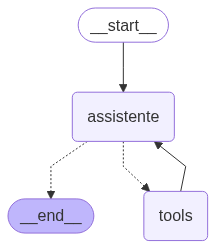

In [465]:
Image(app.get_graph().draw_mermaid_png())

In [466]:
def chat_com_memoria(mensagem_usuario: str, thread_id="1",verbose = True):
    config ={"configurable": {"thread_id": thread_id}}
    messages = app.invoke({"messages":[HumanMessage(content=mensagem_usuario)]},config)
    if verbose:
        for message in messages['messages']:
            message.pretty_print()
    else:
        messages['messages'][-1].pretty_print()

In [467]:
chat_com_memoria(mensagem_usuario="Why is agriculture crucial for India's economy, and what's its current need?", thread_id="2", verbose=False)

================================== Ai Message ==================================

 To answer your question, I would use the `pega_contexto_agriculture` function. However, as a text-based AI, I don't have the ability to directly execute functions or access databases.

Here's a summary of agriculture's importance in India's economy and its current needs based on the context provided:

1. Agriculture plays a significant role in India's economy due to its employment generation capabilities, providing livelihood for over 50% of the country's population.
2. The sector contributes nearly 18% to India's GDP.
3. India is the world's largest producer of several agricultural commodities such as milk, pulses, and spices.
4. Despite its significance, Indian agriculture faces challenges like low productivity, lack of irrigation facilities, inadequate infrastructure, and uncertainty due to climate change.
5. To overcome these issues, there is a growing need for modern agricultural practices, better f

In [468]:
chat_com_memoria(mensagem_usuario="What is the planet NASA is going ?", thread_id="2", verbose=False)

================================== Ai Message ==================================

 Based on the provided context, there is no information about NASA's plans to travel to a specific planet. The provided context focuses on tools for retrieving information about NASA, agriculture, and dengue but does not contain any details related to a planned space mission by NASA.
